In [1]:
from NonlinearController.model_utils import *
from NonlinearController.systems import UnbalancedDisc, SinCosUnbalancedDisc, ReversedSinCosUnbalancedDisc
from matplotlib import pyplot as plt
import deepSI
from casadi import *
import torch
import random
import time

In [2]:
##################  Utility functions  #######################

def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.uniform(level_range[0],level_range[1])))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

def setPointInput(y_ref):
    g = 9.80155078791343
    J = 0.000244210523960356
    Km = 10.5081817407479
    I = 0.0410772235841364
    M = 0.0761844495320390
    tau = 0.397973147009910

    return -(tau * M * g * I)/(Km * J) * np.sin(y_ref)

def my_rk4(x,u,f,dt,M):
    # function MY_RK4
    # used for a discretized simulation of next time-step
    # of the state variables using f(x,u)
    dt = dt/M
    x_next = x
    for i in np.arange(M):
        k1 = dt*f(x,u)
        k2 = dt*f(x+1*k1/2,u)
        k3 = dt*f(x+1*k2/2,u)
        k4 = dt*f(x+1*k3,u)
        x_next = x_next + 1/6*1*(k1+2*k2+2*k3+k4)
    
    return x_next

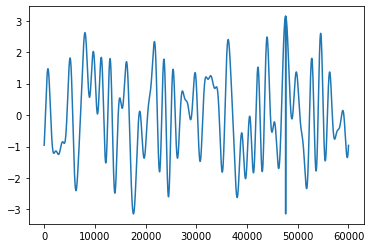

In [7]:
##################  System  #######################
dt = 0.1
# system = UnbalancedDisc(dt=dt)
system = ReversedSinCosUnbalancedDisc(dt=dt, sigma_n=[0.0])

system.reset_state()

##################  MPC variable specification  #######################
Nc=10; nr_sim_steps = int(6e4)

Q = np.array([[10,0],[0,5]]); R = 0.1

w_min = -5; w_max = 5
# q_min = [-np.pi]; q_max = [np.pi]
q_min = [-1.2]; q_max = [1.2]
w0 = 0; q0 = np.array([[0,1]]).T; x0 = np.array([[0,0]]).T

# reference = randomLevelReference(nr_sim_steps+Nc+1, [15,20], [-np.pi,np.pi])
# reference = np.ones(nr_sim_steps+Nc+1)*np.pi/3
reference = deepSI.deepSI.exp_design.multisine(nr_sim_steps+Nc+1, pmin=1, pmax=40, n_crest_factor_optim=20)
reference = reference/(max(reference) - min(reference))*2*np.pi

# reference = np.linspace(0, 2*np.pi, nr_sim_steps+Nc+1)
# reference = np.vstack((np.sin(reference), np.cos(reference)))
# reference = np.hstack((np.zeros(5), -np.pi*np.ones(20) + 0.2, np.ones(30)*np.pi - 0.2))
# reference = np.hstack((np.zeros(10), -np.pi*np.ones(60)))

u_sin = deepSI.deepSI.exp_design.multisine(nr_sim_steps, pmin=nr_sim_steps//16, pmax=nr_sim_steps//2-1, n_crest_factor_optim=10)*0

reference = (reference+np.pi)%(2*np.pi) - np.pi
plt.plot(reference)

In [ ]:
##################  Offline Computation  #######################
# describe physical model
g = 9.80155078791343; J = 0.000244210523960356; Km = 10.5081817407479; l = 0.0410772235841364; M = 0.0761844495320390; tau= 0.397973147009910

nx = 2; x = MX.sym("x",nx,1)
nu = 1; u = MX.sym("u",nu,1)
ny = 2
x_rhs = vertcat(M*g*l/J*np.sin(x[1])-1/tau*x[0]+Km/tau*u, x[0])
y_rhs = vertcat(np.sin(x[1]),np.cos(x[1]))

f = Function('f', [x, u], [x_rhs])
h = Function('h', [x], [y_rhs])

# define initial predicted states and inputs
X0 = np.tile(x0,Nc+1)
U0 = np.ones((Nc)*nu)[np.newaxis]*w0
Y0 = np.tile(q0,Nc)

# define opti stack
opti  = Opti()

states = opti.variable(nx, Nc+1)
controls = opti.variable(nu, Nc)
outputs = opti.variable(ny, Nc)

x_initial = opti.parameter(nx, 1)
y_ref = opti.parameter(ny, Nc)
u_ref = opti.parameter(nu, Nc)

opti.subject_to(opti.bounded(q_min,outputs,q_max))
opti.subject_to(opti.bounded(w_min,controls,w_max))
opti.subject_to(states[:,0] == x_initial)

opti.set_initial(states, X0)
opti.set_initial(controls, U0)
opti.set_initial(outputs, Y0)

opti.set_value(x_initial,X0[:,0])
# opti.set_value(y_ref, reference[:Nc])

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

objective = 0
for i in np.arange(Nc):
    opti.subject_to(states[:,i+1] == my_rk4(states[:,i],controls[:,i],f,dt,2))
    opti.subject_to(outputs[:,i] == h(states[:,i+1]))
    objective = (objective + 
                    mtimes(mtimes((outputs[:,i] - y_ref[:,i]).T,Q),(outputs[:,i] - y_ref[:,i])) +
                    mtimes(mtimes((controls[:,i] - u_ref[:,i]).T,R),(controls[:,i] - u_ref[:,i])))

opti.minimize(objective)

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))

components_time = np.zeros((2, nr_sim_steps))

In [ ]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    component_start = time.time()
    
    opti.set_value(y_ref, np.vstack((np.sin(reference[k:k+Nc]), np.cos(reference[k:k+Nc]))))
    opti.set_value(u_ref, setPointInput(reference[k:k+Nc]))

    components_time[0, k] = components_time[0, k] + time.time() - component_start
    component_start = time.time()

    sol = opti.solve()

    components_time[1, k] = components_time[1, k] + time.time() - component_start
    component_start = time.time()

    U0[0,:] = sol.value(controls)
    X0[:,:] = sol.value(states)
    Y0[:,:] = sol.value(outputs)

    # determine input from optimal velocity input
    u0 = U0[:,0] + u_sin[k]
    # measure output then apply input
    system.x = system.f(system.x, u0[0])
    q1 = np.array(system.h(system.x, u0[0]))
    # predict state with encoder
    x1 = system.x[np.newaxis].T

    # shift predicted states, input, and output one time step k
    X0[:, :-1] = X0[:, 1:]; X0[:, -1:] = X0[:, -2:-1]; X0[:, :1] = x1
    U0[:, :-1] = U0[:, 1:]; U0[:, -1:] = U0[:, -2:-1]; U0[:, :1] = u0
    Y0[:, :-1] = Y0[:, 1:]; Y0[:, -1:] = Y0[:, -2:-1]; Y0[:, :1] = q1[np.newaxis].T

    opti.set_initial(states, X0)
    opti.set_initial(controls, U0)
    opti.set_initial(outputs, Y0)
    opti.set_value(x_initial,x1)

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = u0

    components_time[0, k] = components_time[0, k] + time.time() - component_start

    # print progress
    print("Sim step: " + str(k))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++


In [ ]:
avg_time_step = np.sum(components_time)/nr_sim_steps
avg_time_step, 1 / avg_time_step

In [ ]:
fig1 = plt.figure(figsize=[16, 8])
plt_start = 0; plt_len = 200; plt_end = plt_start + plt_len

plt.subplot(1,3,1)
plt.plot(np.arange(plt_len)*dt, log_w[0,plt_start:plt_end], label='input')
plt.plot(np.arange(plt_len)*dt, setPointInput(reference[plt_start:plt_end]), '--', label='reference')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(1,3,2)
plt.plot(np.arange(plt_len)*dt, log_q[0,:plt_len], label='output')
plt.plot(np.arange(plt_len)*dt, np.sin(reference[:plt_len]), '--', label='reference')
# plt.plot(np.arange(plt_len)*dt, log_q[0,:plt_len] - np.sin(reference[:plt_len]), '-', label='error')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_min[0], 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("sin theta")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(1,3,3)
plt.plot(np.arange(plt_len)*dt, log_q[1,:plt_len], label='output')
plt.plot(np.arange(plt_len)*dt, np.cos(reference[:plt_len]), '--', label='reference')
# plt.plot(np.arange(plt_len)*dt, log_q[1,:plt_len] - np.cos(reference[:plt_len]), '-', label='error')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_min[0], 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("cos theta")
plt.grid()
plt.legend(loc='upper right')

plt.show()

In [4]:
theta = np.arctan2(log_q[0,:], log_q[1,:])
y = (theta[:]+2*np.pi)%(2*np.pi)-np.pi

In [ ]:
# data = system.apply_experiment(deepSI.System_data(u=log_w[0,:]))

In [3]:
# np.save("NonlinearController/data/test_NMPC_w.npy", log_w)
# np.save("NonlinearController/data/test_NMPC_q.npy", log_q)

log_w = np.load("NonlinearController/data/sin_perturbed_NMPC_w.npy")
log_q = np.load("NonlinearController/data/sin_perturbed_NMPC_q.npy")

11.406711772558879

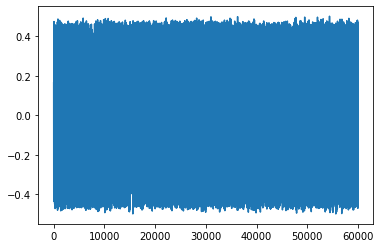

In [17]:
a = log_w[0,:]
range = np.max(a) - np.min(a)
plt.plot(a/range)
range

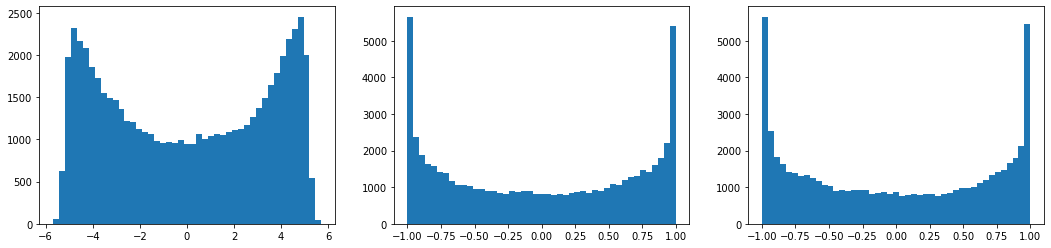

In [5]:
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.hist(log_w[0,:], 45)
plt.subplot(1,3,2)
plt.hist(log_q[0,:], 45)
plt.subplot(1,3,3)
plt.hist(log_q[1,:], 45)
plt.show()

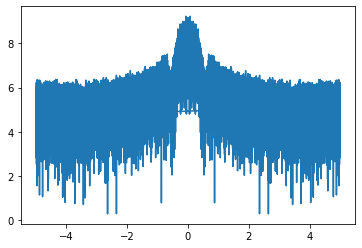

In [8]:
plt.plot(np.fft.fftfreq(nr_sim_steps, d=dt), np.log(abs(np.fft.fft(log_w[0,:])))/1)

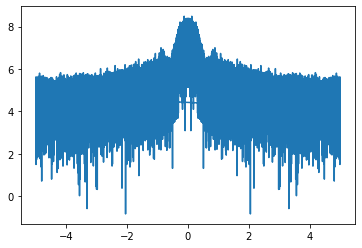

In [9]:
plt.plot(np.fft.fftfreq(nr_sim_steps, d=dt), np.log(abs(np.fft.fft(y)))/1)